In [ ]:
# Add cloud to sst glorys
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

folder_data = "/Odyssey/private/t22picar/data/ssh_L4/"
file_obs = "fdvarnet-glo12-noise-2019.nc" # Actually not glorys 

maps = xr.open_dataset(folder_data+file_obs)

start_date = "2019-01-01"
end_date = "2019-12-31"
maps = maps.sel(time=slice(start_date, end_date))

maps.coords['longitude'] = (maps.coords['longitude'] + 180) % 360 - 180
maps = maps.sortby(maps.longitude)

lat = maps.latitude.values
lon = maps.longitude.values

folder_data_4th = "/Odyssey/private/t22picar/data/glorys_15m/"
file_glorys_4th = "glorys_15.81m_2019-01-01-2020-01-01_4th.nc"

maps_glo_4th = xr.open_dataset(folder_data_4th+file_glorys_4th)

maps = maps.rename({"latitude": "lat"})
maps = maps.rename({"longitude": "lon"})

#maps = maps.rename({"adt": "zos"})

# Original grid 1/12 (2041,4320) --> 1/4
new_sizes = [size // 3 for size in (2041, 4320)]
print('new sizes: {}'.format(new_sizes))

def regrid_da(regrid_sizes, da: xr.DataArray):

        lat_space = np.linspace(start=maps_glo_4th.lat.min(), stop=maps_glo_4th.lat.max(), num=regrid_sizes[0])
        lon_space = np.linspace(start=maps_glo_4th.lon.min(), stop=maps_glo_4th.lon.max(), num=regrid_sizes[1])

        new_da = da.interp({"lat":lat_space, "lon":lon_space}, method="linear")

        return new_da

new sizes: [680, 1440]


In [83]:
maps

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 365, lat: 640, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
  * lat      (lat) float64 5kB -79.0 -78.75 -78.5 -78.25 ... 80.25 80.5 80.75
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    sla      (time, lat, lon) float64 3GB nan nan nan nan ... nan nan nan nan

In [78]:
mdt_file = "/Odyssey/public/data_challenge_ssh_ose/data/maps/DUACS_global_allsat-alg/dt_global_allsat_phy_l4_20191230_20220213.nc"
mdt_xr = xr.open_dataset(mdt_file)
#mdt_xr = mdt_xr.where(mdt_xr.latitude>=-79, drop=True).where(mdt_xr.latitude<=80.75, drop=True)
mdt_xr.coords['longitude'] = (mdt_xr.coords['longitude'] + 180) % 360 - 180
mdt_xr = mdt_xr.sortby(mdt_xr.longitude)
mdt_xr = mdt_xr.interp({"latitude":lat, "longitude":lon}, method="linear")
mdt = mdt_xr.adt.values[:1] - mdt_xr.sla.values[:1]

mdt = np.repeat(mdt, maps.sla.values.shape[0], axis=0)
mdt.shape

(365, 640, 1440)

In [79]:
adt = mdt + maps.sla.values

(array([4.81767416e-02, 2.70633089e-01, 2.40652105e-01, 1.25177701e-01,
        1.05145130e-01, 1.29576934e-01, 1.71003072e-01, 2.01655613e-01,
        1.91658896e-01, 2.96665859e-01, 6.13173796e-01, 8.05088397e-01,
        8.10061979e-01, 6.63327867e-01, 4.57306265e-01, 1.05409577e-01,
        2.94732212e-02, 4.29822961e-03, 6.28322674e-04, 7.69012805e-05]),
 array([-1.57434404, -1.38456153, -1.19477903, -1.00499653, -0.81521403,
        -0.62543153, -0.43564903, -0.24586653, -0.05608403,  0.13369848,
         0.32348098,  0.51326348,  0.70304598,  0.89282848,  1.08261098,
         1.27239348,  1.46217598,  1.65195849,  1.84174099,  2.03152349,
         2.22130599]),
 <BarContainer object of 20 artists>)

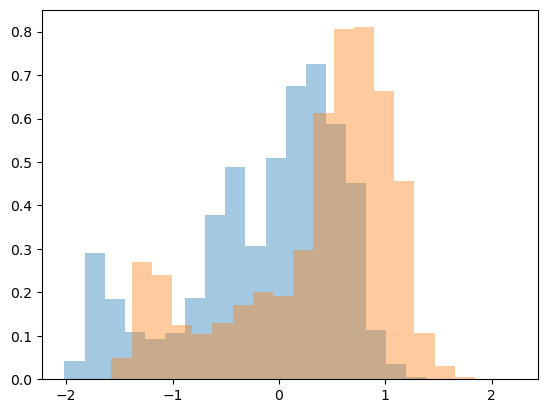

In [80]:
plt.hist(maps_glo_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(adt.ravel(),20,alpha=0.4,density=True,label='4dvar')

In [81]:
mean_glorys_ssh = np.nanmean(maps_glo_4th.zos.values)
mean_4dvar_ssh = np.nanmean(adt)
offset = mean_glorys_ssh-mean_4dvar_ssh

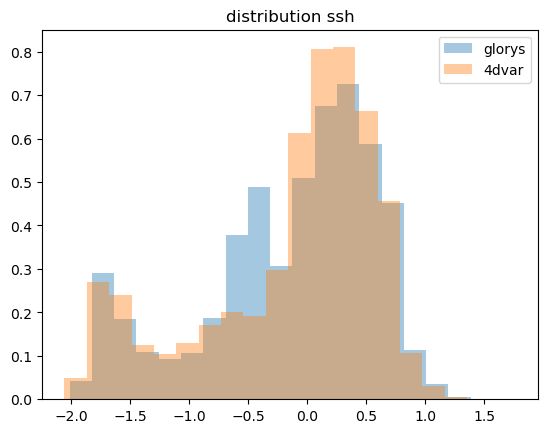

In [82]:

plt.hist(maps_glo_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(adt.ravel()+offset,20,alpha=0.4,density=True,label='4dvar')
plt.title("distribution ssh")
plt.legend()


In [84]:
maps = maps.rename({"sla": "zos"})
# Add offset due to different mdt
maps.zos.values = adt + offset

(array([4.81767416e-02, 2.70633089e-01, 2.40652105e-01, 1.25177701e-01,
        1.05145130e-01, 1.29576934e-01, 1.71003072e-01, 2.01655613e-01,
        1.91658896e-01, 2.96665859e-01, 6.13173796e-01, 8.05088397e-01,
        8.10061979e-01, 6.63327867e-01, 4.57306265e-01, 1.05409577e-01,
        2.94732212e-02, 4.29822961e-03, 6.28322674e-04, 7.69012805e-05]),
 array([-2.06021846, -1.87043596, -1.68065346, -1.49087096, -1.30108846,
        -1.11130595, -0.92152345, -0.73174095, -0.54195845, -0.35217595,
        -0.16239345,  0.02738905,  0.21717155,  0.40695406,  0.59673656,
         0.78651906,  0.97630156,  1.16608406,  1.35586656,  1.54564906,
         1.73543156]),
 <BarContainer object of 20 artists>)

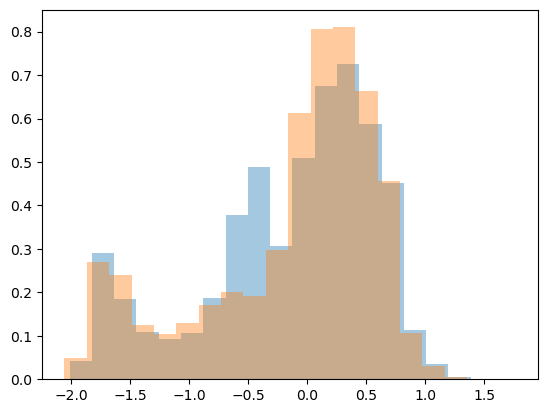

In [85]:
plt.hist(maps_glo_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(maps.zos.values.ravel(),20,alpha=0.4,density=True,label='sat')

In [86]:
# Interpolation new grid
maps_4th = regrid_da(new_sizes,maps)

In [87]:
#Check 
maps_4th.lon - maps_glo_4th.lon

<xarray.DataArray 'lon' (lon: 1440)> Size: 12kB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
    depth    float32 4B ...

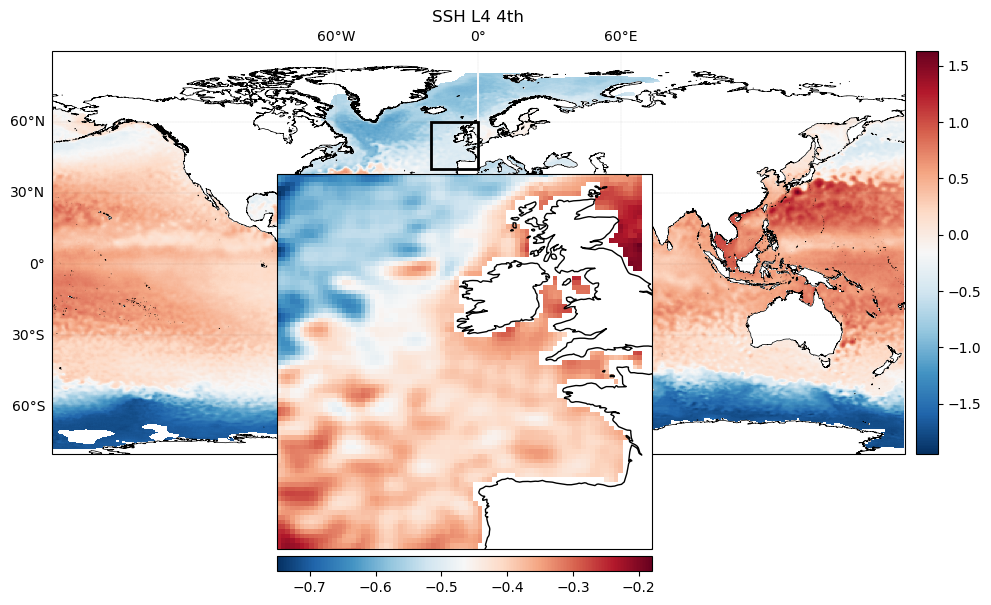

In [88]:
import sys
sys.path.append("/Odyssey/private/t22picar/tools/")
from plot_tools import plot_map_zoom

plot_map_zoom(maps_4th.zos[0],maps_4th.lon.values,maps_4th.lat.values,title="SSH L4 4th")

In [90]:
# save data 
save_file=file_obs[:-3]+"_4th"+".nc"
# Sauvegarder le DataArray en fichier NetCDF
maps_4th.to_netcdf(folder_data+save_file)


In [4]:
# Add cloud to sst glorys
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

folder_data = "/Odyssey/private/t22picar/data/ssh_L4/"
file_glorys = "SSH_L4_CMEMS_2019_4th.nc" # Actually not glorys 

maps_sst = xr.open_dataset(folder_data+file_glorys)
lat_simu = maps_sst.lat.values
lon_simu = maps_sst.lon.values

folder_data_4th = "/Odyssey/private/t22picar/data/glorys_2020_15m/"
file_glorys_4th = "glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
maps_glo = xr.open_dataset(folder_data_4th+file_glorys_4th)

In [6]:
maps_glo.lat

<xarray.DataArray 'lat' (lat: 680)> Size: 5kB
array([-80.      , -79.749632, -79.499264, ...,  89.499264,  89.749632,
        90.      ])
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
Attributes:
    unit_long:      Degrees North
    axis:           Y
    units:          degrees_north
    standard_name:  latitude
    long_name:      Latitude

In [7]:
lon_simu

array([-179.9375    , -179.68741313, -179.43732627, ...,  179.43732627,
        179.68741313,  179.9375    ])